# Partially Bayesian Neural Networks - Simple Regression Example

*Prepared by Maxim Ziatdinov (October 2024)*

This notebook demonstrates the application of partially Bayesian neural networks - where only a subset of weights are probabilistic - on a toy dataset.

Imports:

In [1]:
import sys
sys.path.append("..")

import neurobayes as nb

import numpy as np
import matplotlib.pyplot as plt

Define utility functions for data generation and visualization of results:

In [2]:
def make_data(num_samples=128, noise=0.1, seed=2):
    """
    Based on https://github.com/y0ast/DUE/blob/main/toy_regression.ipynb
    """
    np.random.seed(seed)

    # Generate random weights and biases
    W = np.random.randn(30, 1)
    b = np.random.rand(30, 1) * 2 * np.pi

    # Generate x values
    x = 5 * np.sign(np.random.randn(num_samples)) + \
        np.random.randn(num_samples).clip(-2, 2)

    # Compute y values
    y = np.cos(W * x + b).sum(0) / 5.0 + \
        noise * np.random.randn(num_samples)

    # Reshape and scale
    X = (x[..., None] / 10.0).astype(np.float32)
    y = y[..., None].astype(np.float32)

    return X, y

def plot_results(X, y, X_domain, posterior_mean, posterior_var):
    posterior_mean = posterior_mean.squeeze()
    posterior_var = posterior_var.squeeze()

    _, ax = plt.subplots()
    ax.set_xlabel("$X$")
    ax.set_ylabel("$y$")
    ax.plot(X_domain, posterior_mean, c='r', label='Predictive mean')
    ax.fill_between(X_domain,
                    posterior_mean - np.sqrt(posterior_var),
                    posterior_mean + np.sqrt(posterior_var),
                    color='r', alpha=0.2, label="Predictive uncertainty")
    ax.fill_between(X_domain,
                    posterior_mean - 2*np.sqrt(posterior_var),
                    posterior_mean + 2*np.sqrt(posterior_var),
                    color='r', alpha=0.2)
    ax.scatter(X, y, c='k', s=6, label="Noisy observations", alpha=0.7)
    ax.axis([-1.5, 1.5, -3, 3])
    ax.legend(loc='upper center', fontsize=12)
    plt.show()

Generate synthetic data:

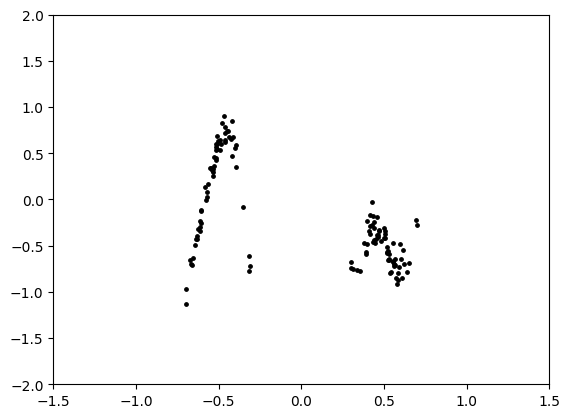

In [3]:
# Generate data
X, y = make_data(num_samples=128)

# Visualize
plt.scatter(X, y, s=6, color = 'k')
plt.axis([-1.5, 1.5, -2, 2])
plt.show()

Define the overall domain for test inputs:

In [4]:
X_domain = np.linspace(-1.5, 1.5, 500)

## Train Determinsitic NN

Initialize and train a simple deterministic neural network:

In [5]:
architecture = nb.FlaxMLP(hidden_dims=[32, 16, 8, 4], target_dim=1)

detnn = nb.DeterministicNN(
    architecture, input_shape=(1,),
    learning_rate=5e-3, map=False
)

detnn.train(X, y, epochs=1000, batch_size=None)

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 1123.62it/s, Epoch 1000/1000, Avg Loss: 0.0114]


Make a prediction:

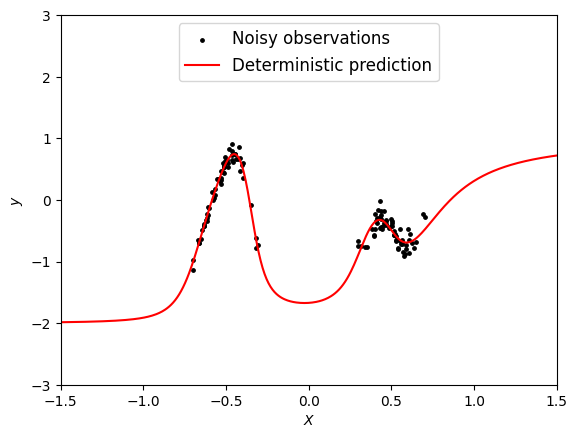

In [6]:
y_pred = detnn.predict(X_domain)

plt.scatter(X, y, s=6, color = 'k', label="Noisy observations")
plt.plot(X_domain, y_pred, c='r', label="Deterministic prediction")
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.axis([-1.5, 1.5, -3, 3])
plt.legend(loc='upper center', fontsize=12)
plt.show()

## Partial BNNs

We will now utilize pre-trained weights to initialize prior distributions for a selected subset of neural network parameters, while keeping the remaining weights frozen. Next, we will perform Hamiltonian Monte Carlo sampling to obtain posterior distributions for the selected subset. Finally, predictions will be made by combining both the probabilistic and deterministic components.

## Partial BNN 1

The last hidden layer (+ output layer) is probabilistic.

In [7]:
pbnn = nb.PartialBNN(detnn.model, detnn.get_params(), num_probabilistic_layers=1)

pbnn.fit(X, y, num_warmup=1000, num_samples=1000)

sample: 100%|██████████| 2000/2000 [00:05<00:00, 398.58it/s, 1023 steps of size 2.88e-03. acc. prob=0.95]


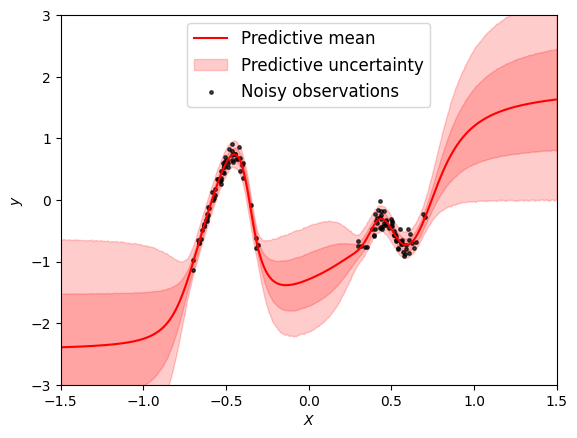

In [8]:
posterior_mean, posterior_var = pbnn.predict(X_domain)

plot_results(X, y, X_domain, posterior_mean, posterior_var)

## Partial BNN 2

The last 2 hidden layers (+ output layer) are probabilistic.

In [9]:
pbnn = nb.PartialBNN(detnn.model, detnn.get_params(), num_probabilistic_layers=2)

pbnn.fit(X, y, num_warmup=1000, num_samples=1000)

sample: 100%|██████████| 2000/2000 [00:13<00:00, 145.84it/s, 1023 steps of size 1.37e-03. acc. prob=0.94]


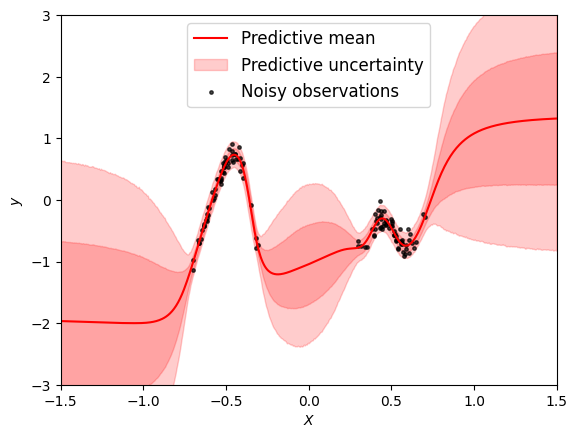

In [10]:
posterior_mean, posterior_var = pbnn.predict(X_domain)

plot_results(X, y, X_domain, posterior_mean, posterior_var)

## Partial BNN 3

The first layer and the output layer are probabilistic.

In [11]:
pbnn = nb.PartialBNN(detnn.model, detnn.get_params(), probabilistic_layer_names=['Dense0', 'Dense4'])

pbnn.fit(X, y, num_warmup=1000, num_samples=1000)

sample: 100%|██████████| 2000/2000 [00:24<00:00, 80.39it/s, 1023 steps of size 4.47e-03. acc. prob=0.86]


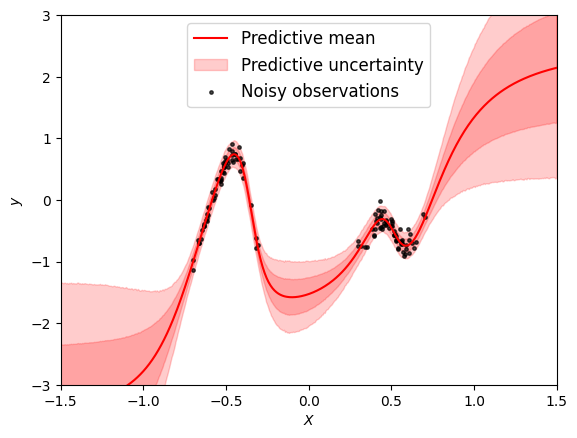

In [12]:
posterior_mean, posterior_var = pbnn.predict(X_domain)

plot_results(X, y, X_domain, posterior_mean, posterior_var)

## Partial BNN - train all at once

In certain scenarios, such as autonomous experiments, the entire training process needs to be performed in an end-to-end manner. In these cases, it is crucial to avoid overfitting in the deterministic component, as there will be no human oversight to evaluate its results before transitioning to the probabilistic part. To address this, we incorporate a MAP prior, modeled as a Gaussian penalty, into the loss function during deterministic training. The strength of this regularization is controlled by the parameter ```map_sigma```, which can either be estimated automatically or set manually.

In [ ]:
model = nb.PartialBNN(architecture, num_probabilistic_layers=2)

model.fit(
    X, y, sgd_epochs=1000, sgd_lr=5e-3,
    map_sigma=nb.utils.calculate_sigma(X),
    num_warmup=1000, num_samples=1000)

Training deterministic NN...


Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 1169.39it/s, Epoch 1000/1000, Avg Loss: 0.2328]


Training partially Bayesian NN


sample: 100%|██████████| 2000/2000 [00:13<00:00, 145.27it/s, 1023 steps of size 1.17e-03. acc. prob=0.96]


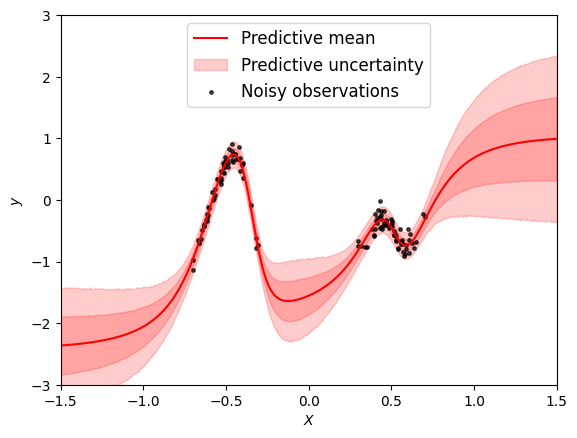

In [14]:
posterior_mean, posterior_var = model.predict(X_domain)

plot_results(X, y, X_domain, posterior_mean, posterior_var)

## Full BNN

Finally, we compare the results with the fully Bayesian approach, where all parameters are treated as probabilistic.

In [15]:
bnn = nb.BNN(architecture)

bnn.fit(X, y, num_warmup=1000, num_samples=1000)

sample: 100%|██████████| 2000/2000 [00:52<00:00, 38.26it/s, 1023 steps of size 5.87e-04. acc. prob=0.89]


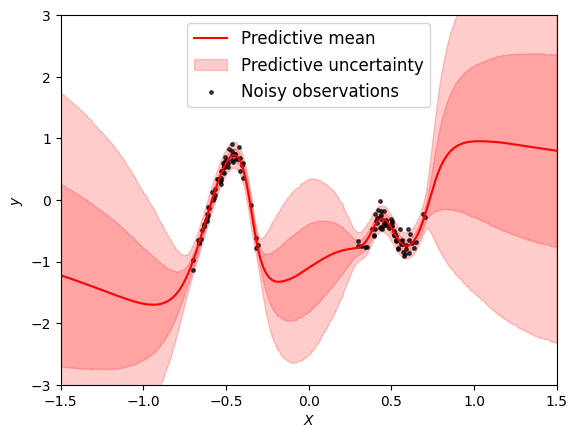

In [16]:
posterior_mean, posterior_var = bnn.predict(X_domain)

plot_results(X, y, X_domain, posterior_mean, posterior_var)